# Forest Cover Type Prediction
### Authors: Maura Cullin, Mike Gruzynski
#### w207 Final project section 3

Introduction: We choose to do the kaggle competition: Forest Cover Type Prediction (https://www.kaggle.com/c/forest-cover-type-prediction). The data comes from US Forest Service (USFS) Region 2 Resource Information System data and the Independent variables were then derived from data obtained from the US Geological Survey and USFS.

This study area includes four wilderness areas located in the Roosevelt National Forest, which is located in northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes (or natural setting) rather than forest management practices.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import sys
import os.path

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import average_precision_score

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.cluster import KMeans

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 1000)

%matplotlib inline

In [8]:
# load the raw dataset
file_path = os.getcwd() + "/final_project"
file_path = os.getcwd() + "/data"
train_df = pd.read_csv(file_path + '/train.csv')
df_train_raw = train_df
target = train_df['Cover_Type']
train_df = train_df.drop('Cover_Type', 1)
train_df = train_df.drop('Soil_Type7', 1)
train_df = train_df.drop('Soil_Type15', 1)
train_df = train_df.drop('Id',1)

# print train_df.head()
test_df = pd.read_csv(file_path + '/test.csv')
# print test_df.head()

predictors = train_df.columns
l = len(target)
X_train, X_dev, y_train, y_dev = train_test_split(train_df, target, test_size=0.30, random_state=42)
print "Train data size %i X %i" % (X_train.shape[0], X_train.shape[1])
print "Test data size %i X %i" % (X_dev.shape[0], X_dev.shape[1])

Train data size 10584 X 52
Test data size 4536 X 52


There is 15120 rows in the dataframe, with no missing data. The data is clean and the only filter that will be performed on the dataset is on "Soil_Type7","Soil_Type15" because there is only values of 0 for all rows in the training data. We will remove the two columns from the data

In [9]:
# setting up variable types
continuous = [
            'Elevation', 'Aspect', 'Slope',
            'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
            'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
            ]

# remove "Soil_Type7","Soil_Type15" because their data was only one value (data cannot be seperable and irrelevantc)
binary = [
        'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
        'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
        'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
        'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
        'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
        'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
        'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
        'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
        'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
        'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
        'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
        'Soil_Type40'
        ]

predictors = continuous + binary

# objective variable is a category
target = 'Cover_Type'

# EDA on the dataset

### Correlation matrix on continuous variables

                                      corr_comparison  corr_value
0                      Hillshade_9am_vs_Hillshade_3pm   -0.779965
1   Horizontal_Distance_To_Hydrology_vs_Vertical_D...    0.652142
2                             Aspect_vs_Hillshade_3pm    0.635022
3                     Hillshade_Noon_vs_Hillshade_3pm    0.614526
4                             Slope_vs_Hillshade_Noon   -0.612613
5                             Aspect_vs_Hillshade_9am   -0.593997
6        Elevation_vs_Horizontal_Distance_To_Roadways    0.578659
7   Horizontal_Distance_To_Roadways_vs_Horizontal_...    0.486386
8     Elevation_vs_Horizontal_Distance_To_Fire_Points    0.443563
9       Elevation_vs_Horizontal_Distance_To_Hydrology    0.412712
10                             Slope_vs_Hillshade_3pm   -0.326887


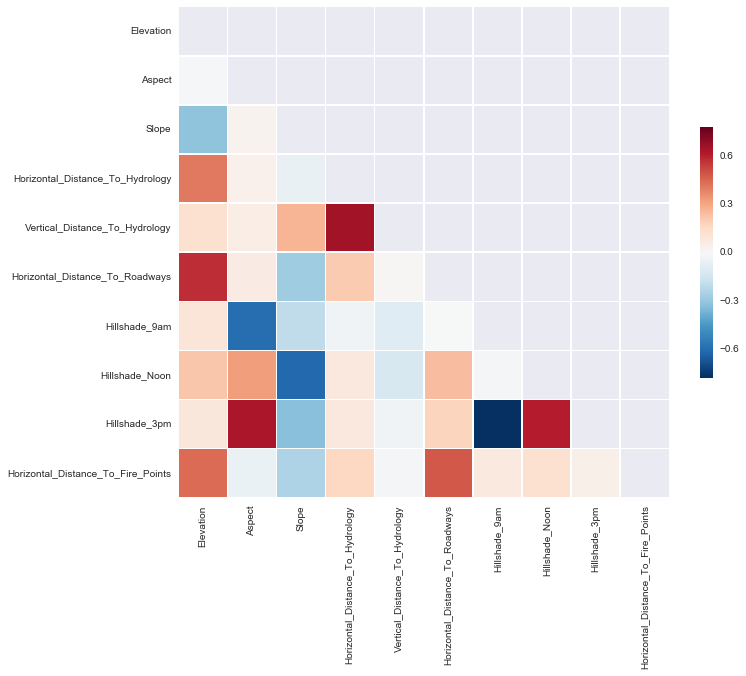

In [10]:
corr = df_train_raw[continuous].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_columns = list(corr.columns)
corr_comparison_list = []
corr_value_list = []
for column in corr:
    temp_corr_columns = corr_columns   
    temp_corr_columns.remove(column)
    for index in corr.loc[temp_corr_columns, column].index:
        corr_comparison_list.append(str(column) + '_vs_' + str(index))
        corr_value_list.append(corr.loc[index, column])
        
corr_df = pd.DataFrame({
    "corr_comparison" : corr_comparison_list,
    "corr_value" : corr_value_list 
})

corr_df = corr_df.iloc[corr_df.corr_value.abs().argsort()][::-1].reset_index()
corr_df = corr_df.loc[:, ~corr_df.columns.str.contains('index')]
print corr_df.loc[:10,:]

Looking at the above correlation matrix, we see combination of variables that may cause collinearity issues in the analysis.

For example Hillshade_3pm is correlated heavily with Hillshade_9am (corr ~ -0.77).

The above dataframe output shows the top 10 (absolute value) correlation values between continuous variables, so we will need to be knowledgeable about having both of the features in the analysis in the top 10 list. The duplicated information may overfit the data and reduce the generalizability of the final analysis

### Skewness information on variables

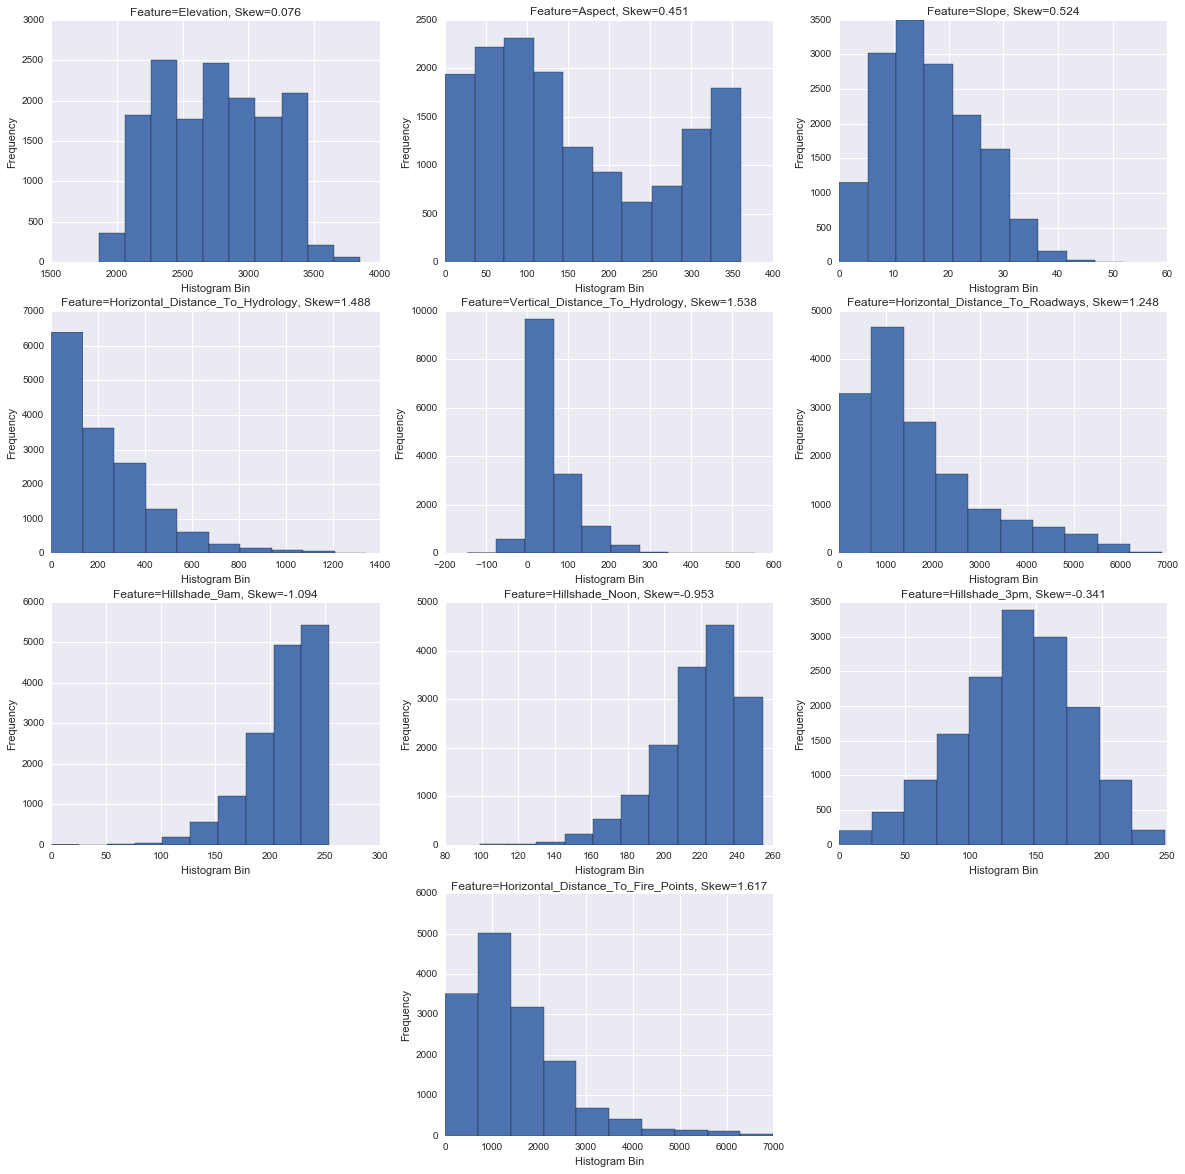

In [11]:
df_train_raw[continuous].skew().sort_values()
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 3) 

itr = 0
for feature in df_train_raw[continuous]:   
    if itr == 9:
        itr += 1
    ax = plt.subplot(gs[itr])
    ax.hist(df_train_raw.loc[:, feature])
    ax.set_xlabel("Histogram Bin")
    ax.set_ylabel("Frequency")
    ax.set_title('Feature={}, Skew={}'.format(feature, round(df_train_raw.loc[:, feature].skew(), 3), fontsize=12))
    
    itr += 1

Looking at the above histograms (with skewness value in the title of each plot), we can see that there are some high skews with potential of some log transformations if the math allows it (i.e cant do a log transformations on a zero) so if the column data has a zero we will have to think of doing something else if needed.

### Visualize continuous variables mapped to 2D plane

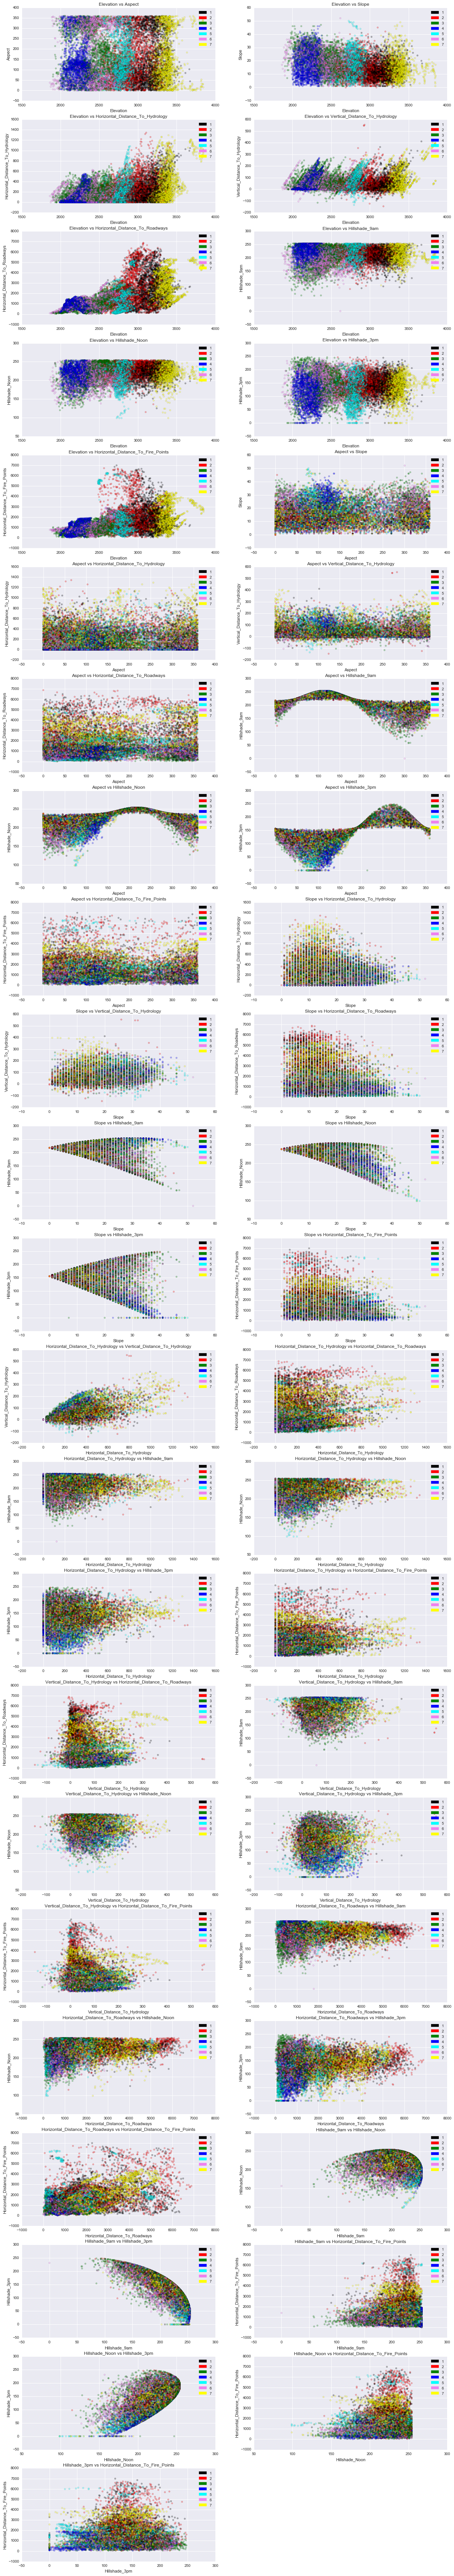

In [12]:
fig = plt.figure(figsize=(20, 120))
gs = gridspec.GridSpec(23, 2) 
df_column_list = list(df_train_raw[continuous].columns)
itr = 0
cmap = mpl.colors.ListedColormap(['black','red', 'green', 'blue', 'cyan', 'violet', 'yellow'])
black_patch = mpatches.Patch(color='black', label='1')
red_patch = mpatches.Patch(color='red', label='2')
green_patch = mpatches.Patch(color='green', label='3')
blue_patch = mpatches.Patch(color='blue', label='4')
cyan_patch = mpatches.Patch(color='cyan', label='5')
violet_patch = mpatches.Patch(color='violet', label='6')
yellow_patch = mpatches.Patch(color='yellow', label='7')


for feature in corr:    
    temp_columns = df_column_list
    index_value = temp_columns.index(feature) + 1
    
    for sub_feature in temp_columns[index_value:]:
        ax = plt.subplot(gs[itr])
        ax.scatter(df_train_raw.loc[:, feature], df_train_raw.loc[:, sub_feature], 
                   c=df_train_raw[target], alpha=0.3, cmap=cmap)
        ax.set_xlabel(feature)
        ax.set_ylabel(sub_feature)
        ax.set_title('{} vs {}'.format(feature, sub_feature, fontsize=12))
        ax.legend(handles=[black_patch, red_patch, green_patch, blue_patch, cyan_patch, violet_patch, yellow_patch])
        itr += 1

After looking at the scatter plots of 2D projection, we can see that there are some very distance regions for target delineation of target cases (the first nine plots - titles shown below):

Elevation vs all of its other covariates

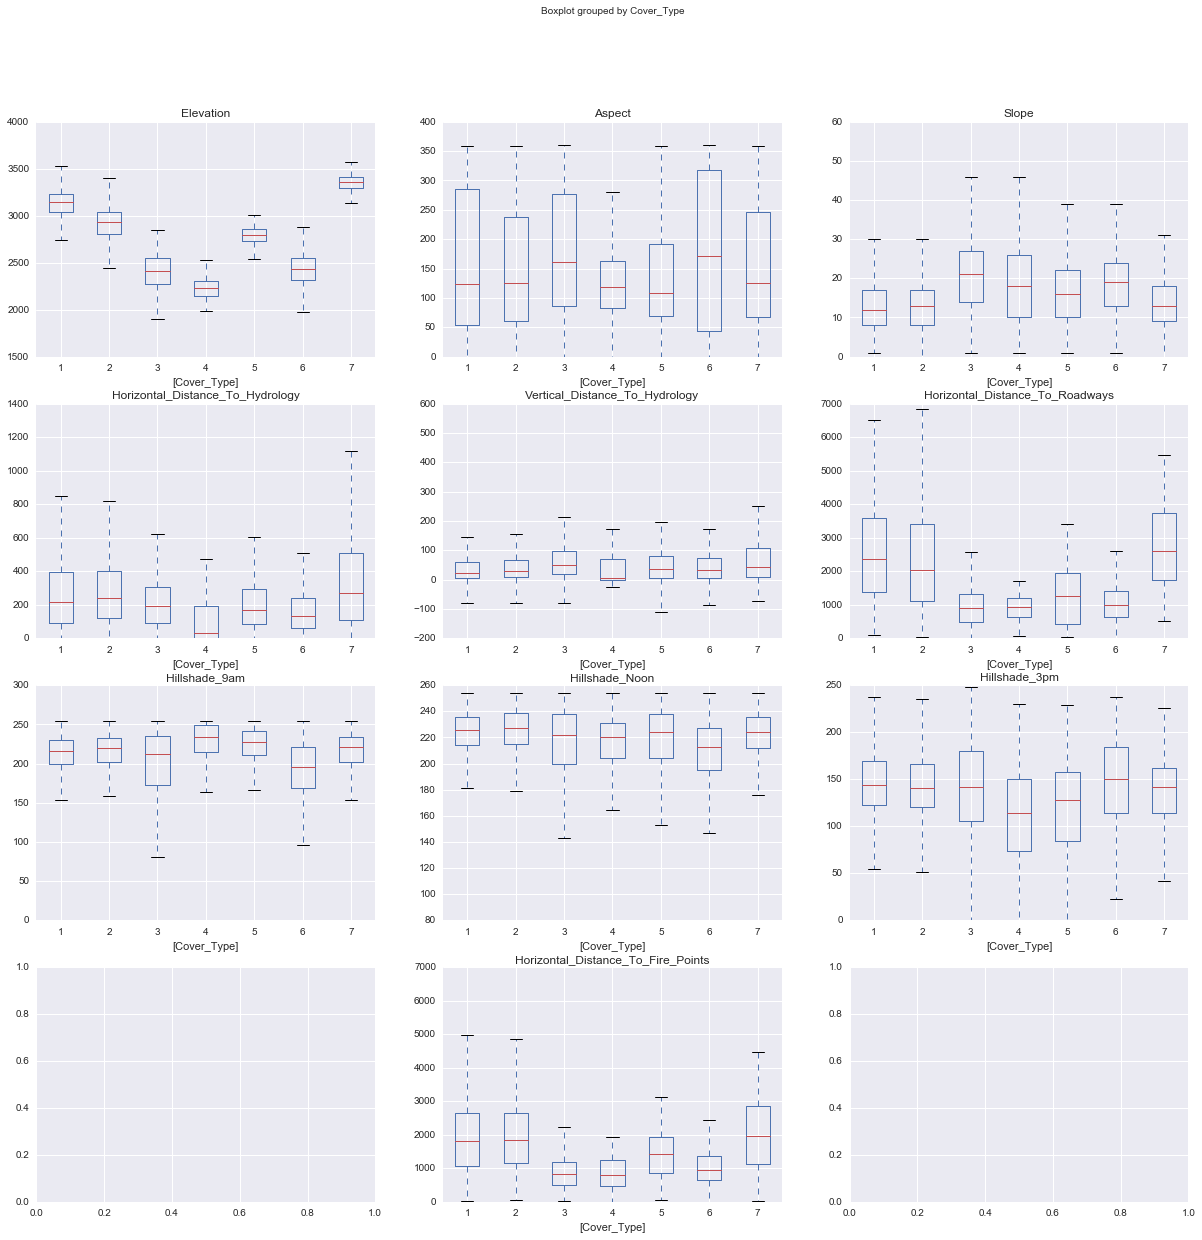

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

itr_1 = 0
itr_2 = 0
for feature in continuous:
    if itr_2 == 3:
        itr_2 = 0
        itr_1 += 1
    if itr_1 == 3:
        itr_2 = 1
    df_train_raw[[feature] + [target]].boxplot(by='Cover_Type', ax=axes[itr_1, itr_2])
    itr_2 += 1
    


Looking at the above boxplots by forest cover type, the elevation shows very distinct values per category. Elevation is looking like it is a very important feature in determining the target value of the problem

### Binary variable exploration

Axes(0.125,0.869;0.352273x0.031)
Axes(0.547727,0.869;0.352273x0.031)
Axes(0.125,0.8318;0.352273x0.031)
Axes(0.547727,0.8318;0.352273x0.031)
Axes(0.125,0.7946;0.352273x0.031)
Axes(0.547727,0.7946;0.352273x0.031)
Axes(0.125,0.7574;0.352273x0.031)
Axes(0.547727,0.7574;0.352273x0.031)
Axes(0.125,0.7202;0.352273x0.031)
Axes(0.547727,0.7202;0.352273x0.031)
Axes(0.125,0.683;0.352273x0.031)
Axes(0.547727,0.683;0.352273x0.031)
Axes(0.125,0.6458;0.352273x0.031)
Axes(0.547727,0.6458;0.352273x0.031)
Axes(0.125,0.6086;0.352273x0.031)
Axes(0.547727,0.6086;0.352273x0.031)
Axes(0.125,0.5714;0.352273x0.031)
Axes(0.547727,0.5714;0.352273x0.031)
Axes(0.125,0.5342;0.352273x0.031)
Axes(0.547727,0.5342;0.352273x0.031)
Axes(0.125,0.497;0.352273x0.031)
Axes(0.547727,0.497;0.352273x0.031)
Axes(0.125,0.4598;0.352273x0.031)
Axes(0.547727,0.4598;0.352273x0.031)
Axes(0.125,0.4226;0.352273x0.031)
Axes(0.547727,0.4226;0.352273x0.031)
Axes(0.125,0.3854;0.352273x0.031)
Axes(0.547727,0.3854;0.352273x0.031)
Axes(0.125,0

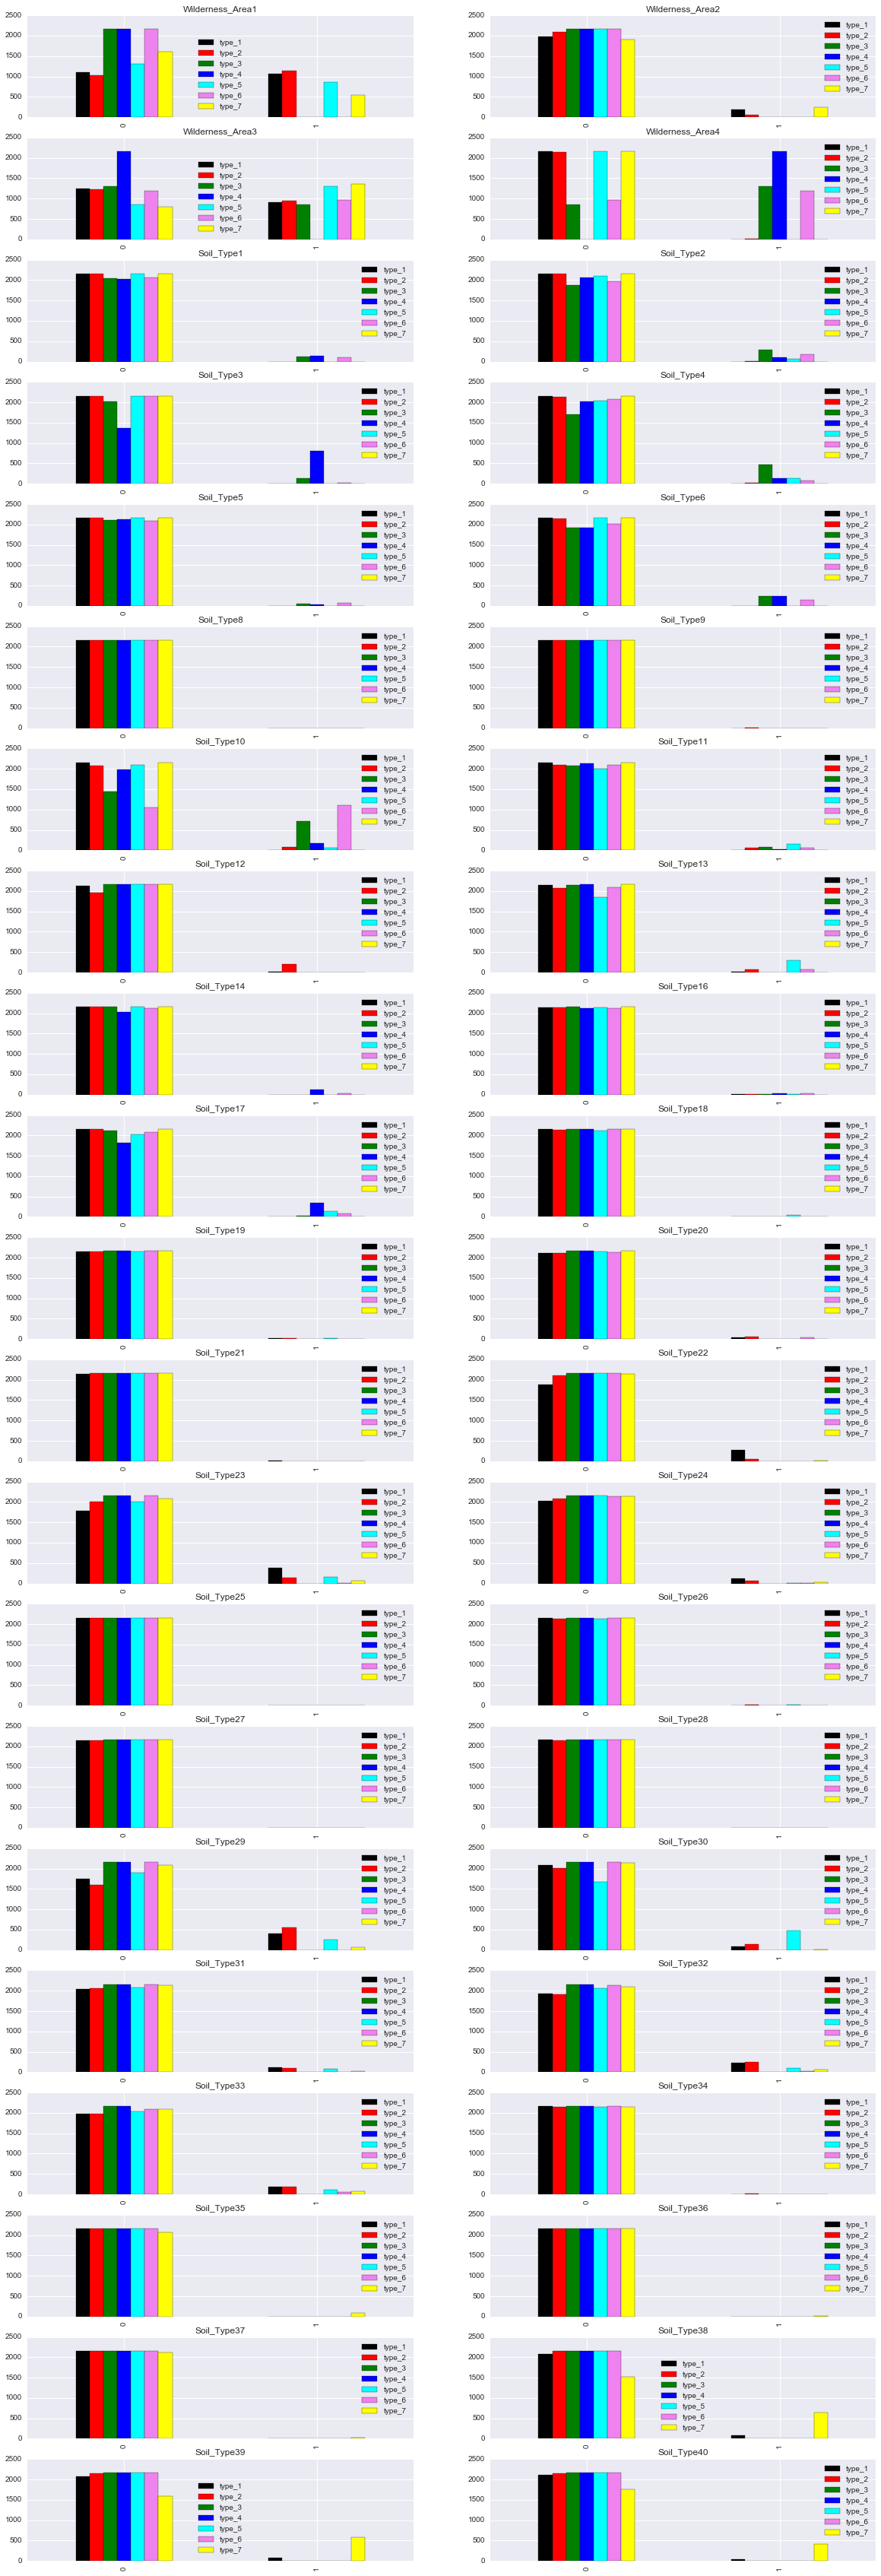

In [14]:
df_binary = df_train_raw[binary + [target]]
fig, axes = plt.subplots(nrows=21, ncols=2, figsize=(20, 60))

df_binary_columns = []
df_dict = {}
itr = 0
master_df = pd.DataFrame()
pic_itr1 = 0
pic_itr2 = 0
for feature in df_binary:
    if 'Cover_Type' not in feature:
        df_binary_columns.append(feature)
        
        if pic_itr2 == 2:
            pic_itr2 = 0
            pic_itr1 += 1
        
        itr = 1
        for name, group in df_binary.loc[:, [feature] + [target]].groupby('Cover_Type'):
            if itr == 1:
                df_out = group[feature].value_counts()
                df_out.name = 'type_{}'.format(itr)
            else:
                df_temp = group[feature].value_counts()
                df_temp.name = 'type_{}'.format(itr)
                df_out = pd.concat([df_out, df_temp], axis = 1)
            itr += 1
            
        
        print df_out.plot(kind='bar', title =feature, 
                          color=['black','red', 'green', 'blue', 'cyan', 'violet', 'yellow'],
                          ax=axes[pic_itr1, pic_itr2])
        master_df = master_df.append(df_out.rename({0: feature + '_0', 1: feature + '_1'}))
        
        pic_itr2 += 1
        
# print master_df

It appears that a lot of the soil type information is very similar with not a lot of added information to the data analysis. This information along with the continuous data information will help make engineering feature elimination decisions.

## PCA Aanlysis

In [15]:
var_explained = 0.95

Keep Number of Compenents: 2, explaining 0.95% Variance


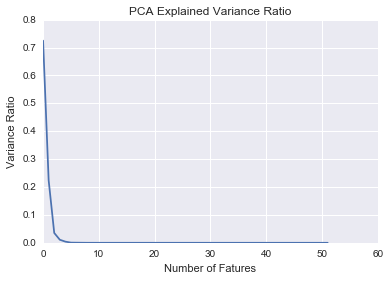

Reduced Train set shape: 10584 X 2


In [16]:
# Method 1
pca = PCA()
pca.fit(X_train)

# Choose number of Compenents to Keep
num_comp = np.sum(np.cumsum(pca.explained_variance_ratio_) < var_explained)
print "Keep Number of Compenents: %i, explaining %0.2f%% Variance" %(num_comp, var_explained)

# plot 
plt.plot(pca.explained_variance_ratio_) 
plt.title("PCA Explained Variance Ratio")
plt.xlabel("Number of Fatures")
plt.ylabel("Variance Ratio")
plt.show()

# Reduce Dataset 
X_reduced1 = PCA(n_components=num_comp).fit_transform(X_train)
print "Reduced Train set shape: %i X %i" % (X_reduced1.shape[0],X_reduced1.shape[1])

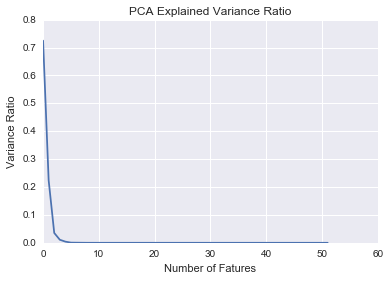

Reduced Train set shape: 10584 X 2


In [17]:
# Method 2
X_reduced2 = pca.transform(X_train)[:, :num_comp]

# plot 
plt.plot(pca.explained_variance_ratio_) 
plt.title("PCA Explained Variance Ratio")
plt.xlabel("Number of Fatures")
plt.ylabel("Variance Ratio")
plt.show()

# Reduce Dataset 
X_reduced1 = PCA(n_components=num_comp).fit_transform(X_train)
print "Reduced Train set shape: %i X %i" % (X_reduced1.shape[0],X_reduced1.shape[1])

In [18]:
# Method 3
Vt = pca.components_[:20, :]
M = X_train - X_train.mean()
U = np.matmul(M, np.transpose(Vt))

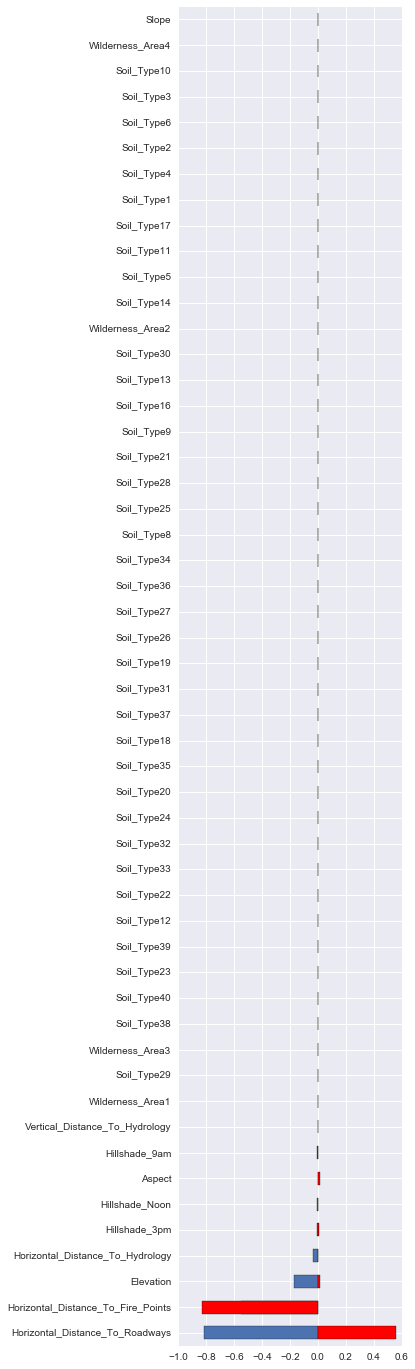

In [19]:
# Show mapping from PCA to original features 
comp0 = pd.Series(dict(zip(X_train.columns, Vt[0, :])))
comp1 = pd.Series(dict(zip(X_train.columns, Vt[1, :])))
col_order = comp0.sort_values().index

plt.figure(figsize=(4, 24))
comp0[col_order].plot(kind='barh')
comp1[col_order].plot(kind='barh', color='red')
plt.show()

## Dimensionality Reduction


In [20]:
def best_features(n_features):
    idx = np.argsort(-feature_importance)[:n_features]
    lr = LinearRegression()
    lr.fit(X_train.iloc[:, idx], y_train)
    return lr.score(X_dev.iloc[:, idx], y_dev)

In [21]:
n_features = len(X_train.columns)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


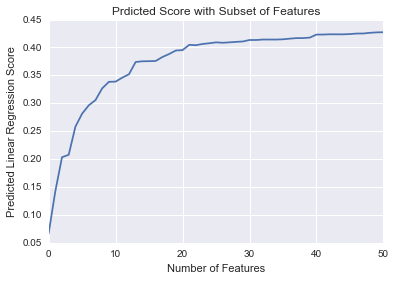

0.427388133301 50


In [22]:
feature_importance = f_regression(X_train, y_train)[0]

out = [best_features(i) for i in range(1, n_features)]

plt.plot(out)
plt.title("Prdicted Score with Subset of Features")
plt.xlabel("Number of Features")
plt.ylabel("Predicted Linear Regression Score")
plt.show()

print np.max(out), np.argmax(out)

In [23]:
# To Look at fetaures used in subset 

# For example only, if a subset of 15 features used: 
feats_to_use = 15
feats = np.argsort(-feature_importance)[:15]
bf_score = best_features(feats_to_use)

print "\nTop 15 Fetaures in Subset Analysis: Best Score %0.2f%%" % bf_score
print " Feature%-30s | Importance Value" % ''
for i in range(15):
    print "%-2i %-35s |  %0.3f" %(i, X_train.columns[feats[i]], feature_importance[feats[i]])


Top 15 Fetaures in Subset Analysis: Best Score 0.38%
 Feature                               | Importance Value
0  Soil_Type38                         |  752.211
1  Soil_Type39                         |  591.015
2  Wilderness_Area1                    |  587.326
3  Soil_Type29                         |  514.597
4  Soil_Type40                         |  456.363
5  Soil_Type22                         |  420.324
6  Soil_Type23                         |  265.404
7  Soil_Type12                         |  181.157
8  Soil_Type32                         |  180.337
9  Soil_Type10                         |  177.807
10 Wilderness_Area3                    |  148.916
11 Horizontal_Distance_To_Roadways     |  140.073
12 Soil_Type24                         |  119.809
13 Soil_Type35                         |  115.935
14 Hillshade_Noon                      |  106.453


In [24]:
def best_components(n_features):
    pca = PCA(n_components=n_features)
    X_transformed = pca.fit_transform(X_train) # choose PCA method from above 
    lr = LinearRegression()
    lr.fit(X_transformed, y_train)
    return lr.score(pca.transform(X_dev), y_dev)

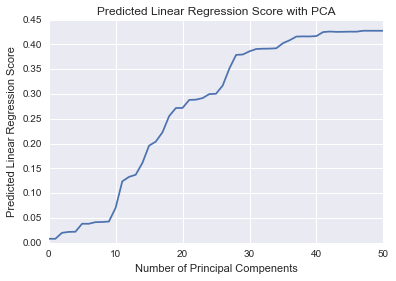

0.427431962577 47


In [25]:
out = [best_components(i) for i in range(1, n_features)]
plt.plot(out)
plt.title("Predicted Linear Regression Score with PCA")
plt.xlabel("Number of Principal Compenents")
plt.ylabel("Predicted Linear Regression Score")
plt.show()

print np.max(out), np.argmax(out)

## Cluster Analysis

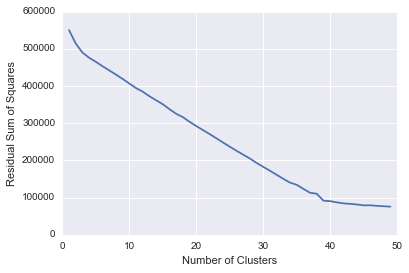

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clusts = range(1, 50 )

def kmean_rss_score(nclust):
    km = Pipeline([('scale', StandardScaler()), ('cluster', KMeans(nclust))])
    km.fit(X_train)
    rss = -km.score(X_train)
    return rss

rss = [kmean_rss_score(i) for i in clusts]
plt.plot(clusts, rss)
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares')
plt.show()

In [27]:
def plot_pca_clusters(train_set,num_clusters):
    print "Training Set Dimensions: %i X %i" % (train_set.shape[0], train_set.shape[1])
    # clusters = [1,16]
    clusters = np.linspace(1,num_clusters,num_clusters, dtype=int)
    position = [(0,0), (0,1), (0,2), (0,3),
                (1,0), (1,1), (1,2), (1,3),  
                (2,0), (2,1), (2,2), (2,3), 
                (3,0), (3,1), (3,2), (3,3)]
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("KMeans Clusters over the 2D Projected data", fontsize="x-large")
    
    for k in clusters:
        km = KMeans(n_clusters=k)
        km.fit(X_train)
        labels = km.labels_
        centroids = km.cluster_centers_
        dists = km.transform(X_train)
        
        # Settings for centroid plots
        if k == 1: 
            point, ms = 'k*', 10
        else: 
            point, ms = '*', 7

        # Plot Clusters
        ax = plt.subplot2grid((4,4), position[k-1])
        plt.set_cmap('tab20')  
        colors = ['#7e1e9c', '#e50000', '#380835', '#ff81c0', '#0343df', '#15b01a', '#f97306', '#00035b',
              '#96f97b', '#6e750e', '#06c2ac', '#95d0fc', '#ff028d', '#516572', '#653700','#ffa756']
        for i in range(k):
            # find max distances from current centroid for radius
            r = np.max(dists[np.where(labels==i)][:,i])
            # select only data observations with cluster label == i
            ds = train_set[np.where(labels==i)]
            # ds = train_set.iloc[np.where(labels==i)]
            # plot the data observations
            ax.plot(ds[:,0],ds[:,1],'.',color = colors[i])
            # plot the centroids and circle with radius to furthest point
            lines = ax.plot(centroids[i,0],centroids[i,1], point, ms=ms)
            circle = plt.Circle((centroids[i,0],centroids[i,1]), r, color='r', alpha=0.2)
            ax.add_artist(circle)
        plt.axis('equal')
        plt.title("KMeans Centroids with " + str(k) + " Cluster(s)")
        fig.show()

Training Set Dimensions: 10584 X 2


ValueError: Colormap tab20 is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

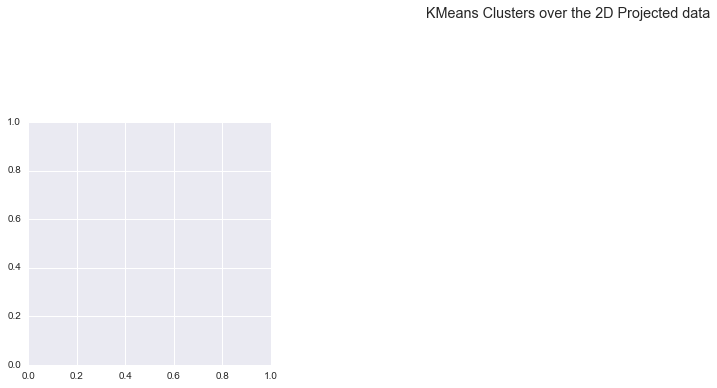

In [28]:
plot_pca_clusters(X_reduced1, num_clusters = 8)

In [ ]:
plot_pca_clusters(X_reduced2, num_clusters = 8)

In [ ]:
# Plot clusters in PCA By true as color
# FROM WEEK 9 Notebook
# import matplotlib.cm as cm

# fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], sharex=False, sharey=False, figsize = (16, 16))

# cmap = cm.jet
# for i, f1 in enumerate(X.columns):
#    for j, f2 in enumerate(X.columns):
#       if not f1 == f2:
#        X.plot(kind='scatter', x=f1, y=f2, c=labels, cmap=cmap, ax=axes[i, j])
        
# plt.show()

In [ ]:
# Heirachical Clustering 
# Could help choose depth of tree (?) 
for i in range(2, 8):
    clusterer = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('kmeans', KMeans(i))
    ])

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

clusters = linkage(X_train, 'ward')
_ = dendrogram(clusters)

## Dtree/RF Feature Importance

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Print Classification Summary Scored in Development 
print "Accuracy Score on Dev Set: %0.2f%%" % (dt.score(X_dev,y_dev))
preds = dt.predict(X_dev)
mse = np.mean((preds - y_dev) ** 2)
print 'Mean squared error = {}'.format(mse)
print 'R^2 = {}\n'.format(dt.score(X_train, y_train))

print metrics.classification_report(y_dev, preds) # target_names = target_names_list)

In [ ]:
# Report Feature Importnace in DTREE 
importance_df = pd.DataFrame({
        'feature': predictors,
        'importance': dt.feature_importances_
    })

importance_df.sort_values('importance').plot(x='feature', kind='bar')

In [ ]:

# only plot importances > 0.01
importance_df1 = importance_df[importance_df['importance'] >= 0.01]
importance_df1.sort_values('importance').plot(x='feature', kind='bar')

## Random Forest

In [ ]:
rf = RandomForestRegressor()
# (n_estimators=500, oob_score=True
rf.fit(X_train,y_train)

scores = cross_val_score(rf, X_train, y_train, cv=10)
print "Mean R^2 = {:.3}".format(scores.mean())

# Print Classification Summary Scored in Development 
print "Accuracy Score on Dev Set: %0.2f%%" % (rf.score(X_dev,y_dev))
preds = rf.predict(X_dev)
mse = np.mean((preds - y_dev) ** 2)
print 'Mean squared error = {}'.format(mse)
print 'R^2 = {}\n'.format(rf.score(X_train, y_train))

# print metrics.classification_report(y_dev, preds) # target_names = target_names_list)

In [ ]:
# Report Feature Importnace in RF 
importance_df = pd.DataFrame({
        'feature': predictors,
        'importance': rf.feature_importances_
    })

importance_df.sort_values('importance').plot(x='feature', kind='bar')

In [ ]:
# only plot importances > 0.01
importance_df1 = importance_df[importance_df['importance'] >= 0.01]
importance_df1.sort_values('importance').plot(x='feature', kind='bar')